In [115]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns
from utils import vec_to_flop, flop_to_vector, VECTOR_IDX_DICT
from utils import (
    SUITEDNESS_DICT, 
    PAIRNESS_DICT, 
    CONNECTEDNESS_DICT, 
    HIGH_LOW_TEXTURE_DICT, 
    HIGH_CARD_DICT, 
    STRAIGHTNESS_DICT)

In [2]:
data = pd.read_parquet("flopdata.parquet")

In [3]:
data = data.astype({
    'suitedness' :int,
    'pairness': int,
    'connectedness':int,
    'high_low_texture' :int,
    'high_card': int,
    'straightness': int
    
})

In [20]:
data['suitedness_cat'] = pd.Categorical(
    data['suitedness'].apply(lambda x: SUITEDNESS_DICT[x]),
    categories=['rainbow','two_tone','monotone'],
    ordered=True)

data['pairness_cat'] = pd.Categorical(
    data['pairness'].apply(lambda x: PAIRNESS_DICT[x]),
    categories=['unpaired','low_pair','middle_pair','high_pair'],
    ordered=True)

data['connectedness_cat'] = pd.Categorical(
    data['connectedness'].apply(lambda x: CONNECTEDNESS_DICT[x]), 
    categories=['disconnected','two_connected','three_connected'],
    ordered=True)

data['high_low_text_cat'] = pd.Categorical(
    data['high_low_texture'].apply(lambda x: HIGH_LOW_TEXTURE_DICT[x]),
    categories=['low','middle','high'],
    ordered=True)

data['high_card_cat'] = pd.Categorical(
    data['high_card'].apply(lambda x: HIGH_CARD_DICT[x]),
    categories=['2high','3high','4high','5high','6high','7high','8high','9high','Thigh','Jhigh','Qhigh','Khigh','Ahigh'],
    ordered=True)

data['straightness_cat'] = pd.Categorical(
    data['straightness'].apply(lambda x: STRAIGHTNESS_DICT[x]),
    categories=['no_possible','one_possible','two_possible','three_possible'],
    ordered=True)



In [21]:
flop_vectors = np.array(data['flop_encoded'].tolist())

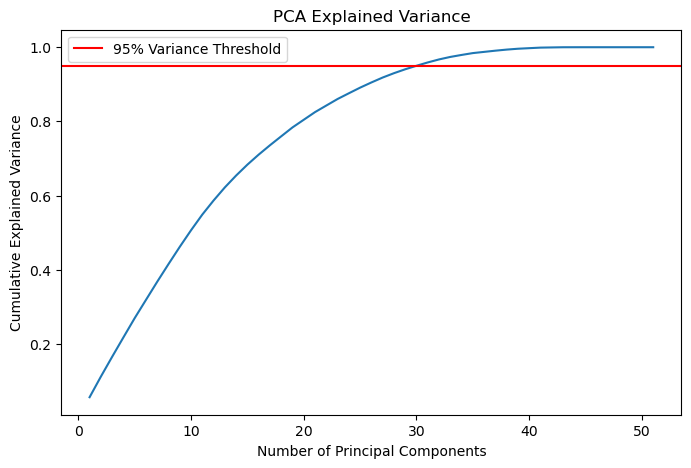

In [94]:
pca = PCA()
X_pca = pca.fit_transform(flop_vectors)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.axhline(y=0.95, color='r', label="95% Variance Threshold")
plt.legend()
plt.show()


In [95]:
opt_num_components = np.argmax(explained_variance >= 0.95) + 1
print(opt_num_components)

31


In [96]:
pca = PCA(n_components=opt_num_components)
X_reduced = pca.fit_transform(flop_vectors)

In [97]:
pca.explained_variance_

array([0.2728219 , 0.27064916, 0.26050692, 0.2552024 , 0.25280591,
       0.23974099, 0.23891176, 0.23194931, 0.22685182, 0.21783564,
       0.20622186, 0.18506702, 0.17211404, 0.15580151, 0.14330535,
       0.13157352, 0.12295688, 0.11768719, 0.1168382 , 0.10073451,
       0.1006394 , 0.0862277 , 0.0859312 , 0.07522459, 0.07410844,
       0.06815989, 0.06463596, 0.05700816, 0.05150566, 0.04615094,
       0.04372247])

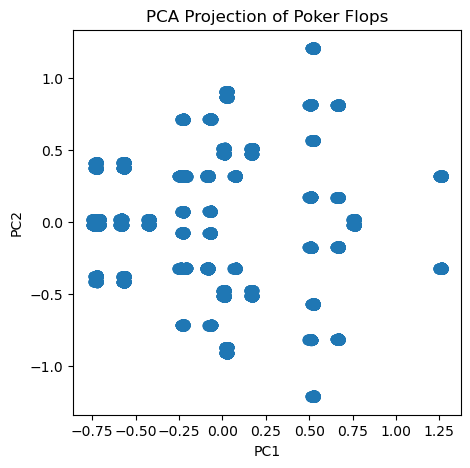

In [98]:
plt.figure(figsize=(5,5))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Poker Flops")
plt.show()

In [106]:
pc_data = pd.concat(
    [data, pd.DataFrame(X_reduced,columns=[f'pc{i}' for i in range(1,opt_num_components+1)])], 
     axis=1
     )

In [100]:
from itertools import product
from scipy.stats import spearmanr

In [107]:
pc_cols = [col for col in pc_data.columns if 'pc' in col]
attr_cols = [
    'suitedness',
    'pairness',
    'connectedness',
    'high_low_texture',
    'high_card',
    'straightness'
]

In [108]:
spear_corr_res = []
for attr, pc in product(attr_cols, pc_cols):
    res = spearmanr(pc_data[[attr,pc]].to_numpy())
    spear_corr_res.append({
        'attr': attr,
        'pc': pc,
        'stat': res.statistic,
        'pval': res.pvalue
    })
spear_corr_df = pd.DataFrame(spear_corr_res)

In [110]:
spear_corr_df[spear_corr_df.pval < .05].sort_values(by='stat',key=np.abs, ascending=False).round(4).head(15)

,attr,pc,stat,pval
104,high_low_texture,pc12,0.6214,0.0
102,high_low_texture,pc10,-0.6163,0.0
106,high_low_texture,pc14,0.5218,0.0
137,high_card,pc14,0.3997,0.0
135,high_card,pc12,0.3768,0.0
143,high_card,pc20,0.3263,0.0
144,high_card,pc21,-0.3222,0.0
182,straightness,pc28,0.3114,0.0
108,high_low_texture,pc16,0.2972,0.0
180,straightness,pc26,0.2507,0.0
